Explore the dataset and figure out: 
1. Distribution of bounding box height
2. Distribution of bounding box width
3. Distribution of aspect ratio

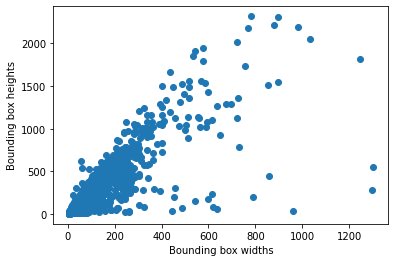

It seems that the average aspect ratio is about 2:1


In [7]:
import json
import matplotlib.pyplot as plt

with open("data/raw/crowdhuman_debug/annotations/train.json", 'r') as file:
    annotations = json.load(file)
    annotations = annotations['annotations']    

bboxes = [ann['bbox'] for ann in annotations]
heights = [bbox[3] for bbox in bboxes]
widths = [bbox[2] for bbox in bboxes]
plt.scatter(widths, heights)
plt.xlabel("Bounding box widths")
plt.ylabel("Bounding box heights")
plt.show()
print("It seems that the average aspect ratio is about 2:1")

The main source of memory consumption in the TFLiteMicro model is the intermediate activations. The number of activations is directly proportional to the size of the input image. Therefore the best way to reduce model size is to have a small input image. 

Proposal: Train a model to detect a person or not, and then use 2:1 scaling + pyramid of features to detect future instances of people. 

E.g. for a 320x240 input image, first rescale it to 64 x 32 and do a detection. If person detected, zoom out 2x and do a detection on each quadrant. Repeat as necessary until no more detections. 

In [8]:
def load_tfrecords(dataset_name, split="train"):
    """
    split: 'train', 'val', or 'testdev'
    """
    datadir = pathlib.Path('data/classification_tfrecord') / dataset_name
    filenames = [str(p) for p in datadir.glob(f"coco_{split}.record*")]
    tfrecords = tf.data.TFRecordDataset(filenames)
    return tfrecords

In [9]:
import tensorflow as tf
import pathlib

def _example_to_tensors(example, input_shape):
    example = tf.io.parse_example(
        example[tf.newaxis], {
            'image/encoded': tf.io.FixedLenFeature(shape = (), dtype=tf.string),
            'image/class': tf.io.FixedLenFeature(shape = (), dtype=tf.int64)
        })
    img_tensor =  tf.io.decode_jpeg(example['image/encoded'][0])
    img_tensor = tf.image.resize(img_tensor, size=(input_shape.height, input_shape.width))
    label = example['image/class']
    return img_tensor, label

def load_dataset(dataset_name, input_shape, split="train"):
    """
    split: 'train', 'val', or 'testdev'
    """
    datadir = pathlib.Path('data/classification_tfrecord') / dataset_name
    filenames = [str(p) for p in datadir.glob(f"coco_{split}.record*")]
    tfrecords = tf.data.TFRecordDataset(filenames)
    def _map_fn(example):
        return _example_to_tensors(example, input_shape)
    dataset = tfrecords.map(_map_fn)
    return dataset
    


/opt/conda/envs/tf-detect/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


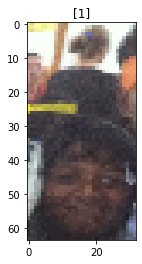

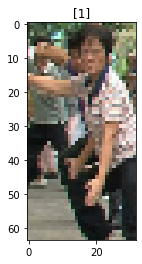

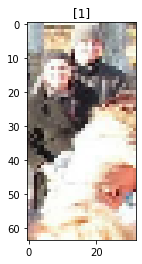

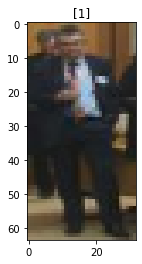

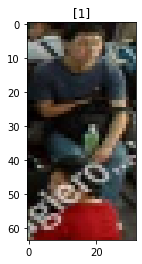

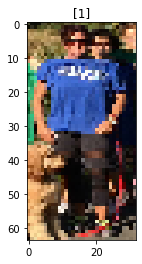

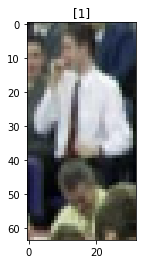

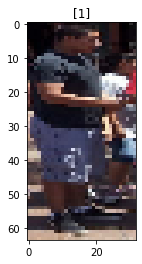

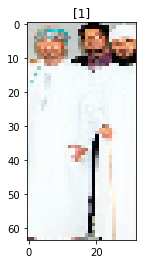

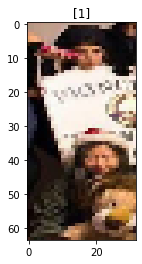

In [10]:
import matplotlib.pyplot as plt
from collections import namedtuple

ImgShape = namedtuple('ImageShape', 'height width channels')
INPUT_SHAPE = ImgShape(height=128, width=64, channels=3)
    
train_dataset = load_dataset('crowdhuman', INPUT_SHAPE, split="train")
val_dataset = load_dataset('crowdhuman', INPUT_SHAPE, split="val")

for img, label in train_dataset.shuffle(128).take(5):
    plt.figure()
    plt.imshow(img.numpy() / 255)
    plt.title(label.numpy())
    
for img, label in val_dataset.shuffle(128).take(5):
    plt.figure()
    plt.imshow(img.numpy() / 255)
    plt.title(label.numpy())

In [18]:
def build_model(input_shape: ImgShape):
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    # preprocess_input expects numbers in the range [0,255] and scales it to [-1, 1]
    preprocess_input = tf.keras.applications.mobilenet.preprocess_input
    backbone = tf.keras.applications.MobileNet(input_shape=(64, 32,3), alpha=0.15, include_top=False, weights=None)
    classifier = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(2)
    ])

    inputs = tf.keras.Input(input_shape)
    x = inputs
    x = data_augmentation(x)
    x = preprocess_input(x)
    x = backbone(x)
    x= classifier(x)
    outputs = x
    model = tf.keras.Model(inputs, outputs)
    return model

model = build_model(INPUT_SHAPE)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 32, 3)         0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 64, 32, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 64, 32, 3)         0         
_________________________________________________________________
mobilenet_0.15_64 (Functiona (None, 2, 1, 153)         82771     
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 3902      
Total params: 86,673
Trainable params: 83,423
Non-trainable params: 3,250
______________________________________________

Overfit experiment. 

If our dataset is well-formed, the model should be able to overfit a small dataset. 

In [1]:
! python src/train_classification_model.py --dataset crowdhuman_debug --verbose 1 --alpha 1.0 --input-height=256 --input-width=128

2020-09-03 14:30:14.806548: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-03 14:30:16.298901: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-03 14:30:18.255755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-03 14:30:18.256678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-09-03 14:30:18.256736: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-03 14:30:18.258950: I tensorflow/stream_executor/platform/defa

2020-09-03 14:30:37.562672: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 256.00MiB (rounded to 268435456)requested by op functional_1/mobilenet_1.00_256/conv_dw_5_bn/FusedBatchNormV3
Current allocation summary follows.
2020-09-03 14:30:37.562749: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2020-09-03 14:30:37.562793: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 84, Chunks in use: 84. 21.0KiB allocated for chunks. 21.0KiB in use in bin. 4.8KiB client-requested in use in bin.
2020-09-03 14:30:37.562818: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 24, Chunks in use: 24. 12.2KiB allocated for chunks. 12.2KiB in use in bin. 12.0KiB client-requested in use in bin.
2020-09-03 14:30:37.562840: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 20, Chunks in use: 20. 21.5KiB allocat

Traceback (most recent call last):
  File "src/train_classification_model.py", line 154, in <module>
    main()
  File "src/train_classification_model.py", line 147, in main
    history = model.fit(x = train_dataset, validation_data = val_dataset, epochs=args.epochs, callbacks=callbacks, verbose=args.verbose)
  File "/opt/conda/envs/tf-detect/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 103, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/opt/conda/envs/tf-detect/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py", line 1102, in fit
    tmp_logs = self.train_function(iterator)
  File "/opt/conda/envs/tf-detect/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 796, in __call__
    result = self._call(*args, **kwds)
  File "/opt/conda/envs/tf-detect/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 856, in _call
    return self._stateless_fn(*args, **kwds)
  File "/